In [1]:
import numpy as np
import math
import pandas
import geopandas
import networkx as nx
import osmnx as ox
import shapely
import shapely.geometry
from shapely.geometry import LineString, mapping, Polygon
import geopandas as gpd
from ipyleaflet import *
from ipywidgets import Layout
import geopy.distance
import contextily
import matplotlib.pyplot
import Modules.Du as D
import Modules.gargi as G


In [2]:
# # Define the folder containing the database
data_folder = r".\Modules\Assets\GPR"
image_folder_gargi = r".\Modules\Assets\Drones\Bridge"
du_result = D.call_du(data_folder) #calling the result
gargi_result = G.call_gargi(image_folder_gargi)

# print(du_result)  # Print to see the result
print(du_result)
print(gargi_result)


   Longitude   Latitude  Distance
0   4.354011  52.015956  5.857143
1   4.354011  52.015956  3.821429
2   4.354011  52.015956  3.428572
   Longitude   Latitude Safety Status
0   4.348486  52.008519      Not Safe
1   4.348506  52.008531      Not Safe
2   4.348481  52.008514      Not Safe


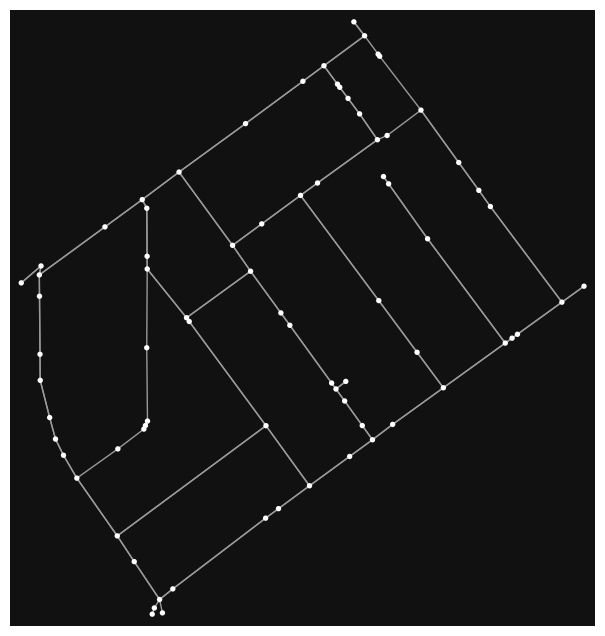

In [3]:
# Create polygon from lists of points
x = [4.347663, 4.352337, 4.349946, 4.346000, 4.346000]
y = [52.006884, 52.008783, 52.010765, 52.009467, 52.008111]

place_polygon = shapely.geometry.Polygon(zip(x,y))
# Retrieve the network graph
graph = ox.graph_from_polygon(
    # place_polygon.at[0, "geometry"],
    place_polygon,
    network_type="drive_service",
    simplify=False
)

fig, ax = ox.plot_graph(graph)

In [4]:
nodes, edges = ox.graph_to_gdfs(graph)

In [5]:
# Retrieve edges & nodes from the graph
#collect data with real distance of the road
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)
lengthdict = nx.get_edge_attributes(graph, 'length')

# print(edges['geometry'].iloc[4].coords[0])
# print(edges['geometry'].iloc[4].coords[1])
# print((edges['geometry'].iloc[4].coords[0][0]+edges['geometry'].iloc[4].coords[1][0])/2)
# print((edges['geometry'].iloc[4].coords[0][1]+edges['geometry'].iloc[4].coords[1][1])/2)
# print(df.shape[0])
# lat = []
# lon = []
# for i in range(df.shape[0]): 
#     lat.append((edges['geometry'].iloc[i].coords[0][0]+edges['geometry'].iloc[i].coords[1][0])/2)
#     lon.append((edges['geometry'].iloc[i].coords[0][1]+edges['geometry'].iloc[i].coords[1][1])/2)
# edges['lon'] = lat
# edges['lat'] = lon
edges.to_excel(excel_writer="./cache/test.xlsx")

In [6]:
df = pandas.DataFrame.from_dict(lengthdict, orient='index', columns=['length'])
df.reset_index(inplace=True)
df = df.rename(columns={"index": "edges"})

In [7]:
# fake width data as a default
# for i in range(Dudf.shape[0]):
#     df.loc[df["edges"] == (osmnx.nearest_edge(DUdf["x"].iloc[i], "y") -> format off((u,v,k))), "usefull-width"] = DUdf["width"].iloc[i]

In [8]:
while(1):
    user_input = input("Car or Truck (Case-sensitve)")
    if user_input == "Car" or user_input == "Truck":
        break
    print(f"Please fill in either Car or Truck and not '{user_input}'")

In [9]:
df['useful-width'] = 10.0 

#get Du's data for pictures being taken in this area
for i in range(du_result.shape[0]):
    u, v, k = ox.nearest_edges(graph, du_result["Longitude"].iloc[i], du_result["Latitude"].iloc[i])
    way1 = (u, v, k)
    way2 = (v, u, k)
    print(way1)
    print(way2)
    df.loc[df["edges"] == way1, 'useful-width'] = du_result["Distance"].iloc[i]
    df.loc[df["edges"] == way2, 'useful-width'] = du_result["Distance"].iloc[i]

df['K'] = 1 / df['useful-width']

#find broken bridges from Gargi and reassign k = 999 to thoese bridges
for i in range(gargi_result.shape[0]):
    u, v, k = ox.nearest_edges(graph, gargi_result["Longitude"].iloc[i], gargi_result["Latitude"].iloc[i])
    way1 = (u, v, k)
    way2 = (v, u, k)
    print(way1)
    print(way2)
    df.loc[df["edges"] == way1, 'K'] = 999
    df.loc[df["edges"] == way2, 'K'] = 999

if user_input == "Car":
    df.loc[df['useful-width'] < 3.00, 'K-corrected'] = 999
    df.loc[df['useful-width'] >= 3.00, 'K-corrected'] = df['K']
else:
    df.loc[df['useful-width'] < 4.5, 'K-corrected'] = 999
    df.loc[df['useful-width'] >= 4.5, 'K-corrected'] = df['K']
df['weight'] = df['length'] * df['K-corrected']
df
# print(df.loc[df["K"] == 999]) #check Gargi works
df.to_excel("cache/test.xlsx")

(44846109, 44846571, 0)
(44846571, 44846109, 0)
(44846109, 44846571, 0)
(44846571, 44846109, 0)
(44846109, 44846571, 0)
(44846571, 44846109, 0)
(44835264, 10877175239, 0)
(10877175239, 44835264, 0)
(44835264, 10877175239, 0)
(10877175239, 44835264, 0)
(44835264, 10877175239, 0)
(10877175239, 44835264, 0)


In [10]:


# # fake width data as a default
# # for i in range(Dudf.shape[0]):
# #     df.loc[df["edges"] == (osmnx.nearest_edge(DUdf["x"].iloc[i], "y") -> format off((u,v,k))), "usefull-width"] = 999
# for i in range(gargi_result.shape[0]):
#     df.loc[df["edges"] == ox.nearest_edges(graph, gargi_result["Longitude"].iloc[i], gargi_result["Latitude"].iloc[i]), 'K'] = 999

# print(df.loc[df["K"] == 999])
    
    

In [11]:
d_K = dict(zip(df['edges'], df['K']))
d_useful_width = dict(zip(df['edges'], df['useful-width']))
d_weight = dict(zip(df['edges'], df['weight']))

nx.set_edge_attributes(graph, d_weight, 'weight')
nx.set_edge_attributes(graph, d_K, 'K')
nx.set_edge_attributes(graph, d_useful_width, 'useful-width')

In [12]:
#Backup
graphInter = graph.copy()
edgesInter = edges.copy()
nodesInter = nodes.copy()

In [13]:
# Transform the graph to UTM
graph = ox.project_graph(graph) 

# Extract reprojected nodes and edges
nodes, edges = ox.graph_to_gdfs(graph)

In [14]:
convex_hull = edges.unary_union.convex_hull
stats = ox.basic_stats(graph, area=convex_hull.area)

In [15]:
origin = (
    ox.geocode_to_gdf("Frits Diepenlaan", which_result=1)  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    ox.geocode_to_gdf("prunusstraat, schipluiden", which_result=1)
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

In [16]:
origin_node_id = ox.nearest_nodes(graph, origin.x, origin.y)
destination_node_id = ox.nearest_nodes(graph, destination.x, destination.y)
# Find the shortest path between origin and destination
route = nx.shortest_path(graph, origin_node_id, destination_node_id, 'weight', method='dijkstra')

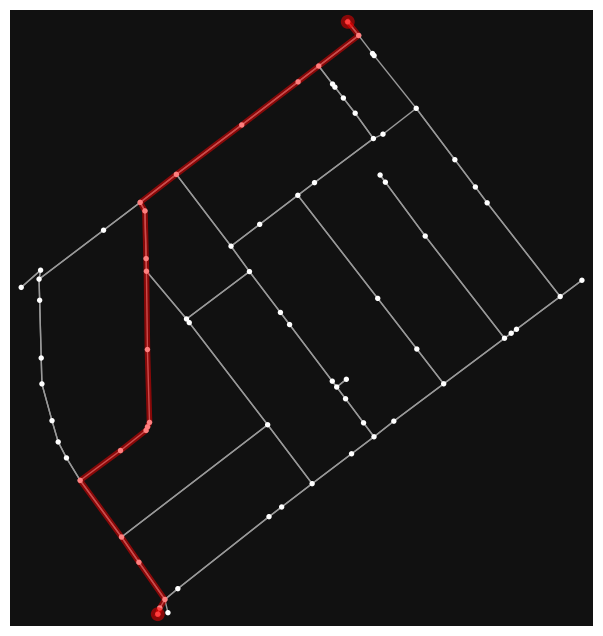

In [17]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(graph, route)

In [18]:
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]

In [19]:
# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)

In [20]:
route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

In [21]:
buildings = ox.features_from_polygon(
    place_polygon,
    {
        "building" : True
    }
).to_crs(edges.crs)

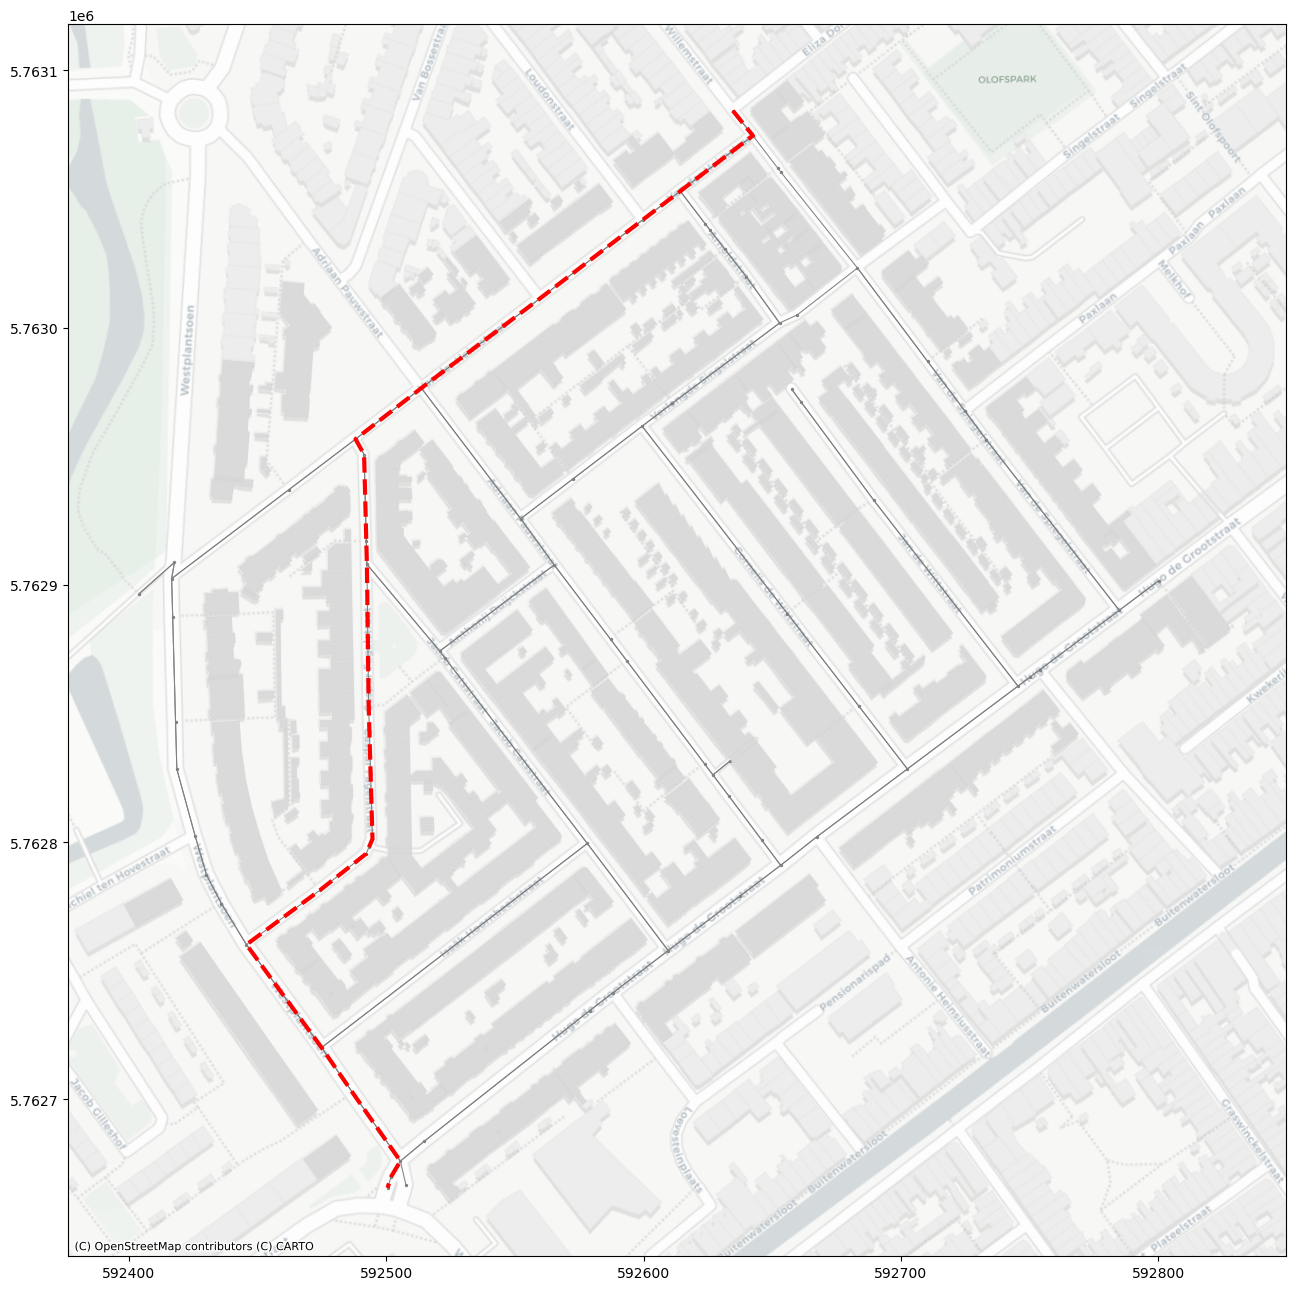

In [22]:
fig, ax = matplotlib.pyplot.subplots(figsize=(24,16))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=3, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)



In [23]:
#convert x,y value into (u,v,k) format
ox.distance.nearest_edges(graph, 4.3708, 52.00478, interpolate=None, return_dist=False)

(1010679591, 6883743181, 0)

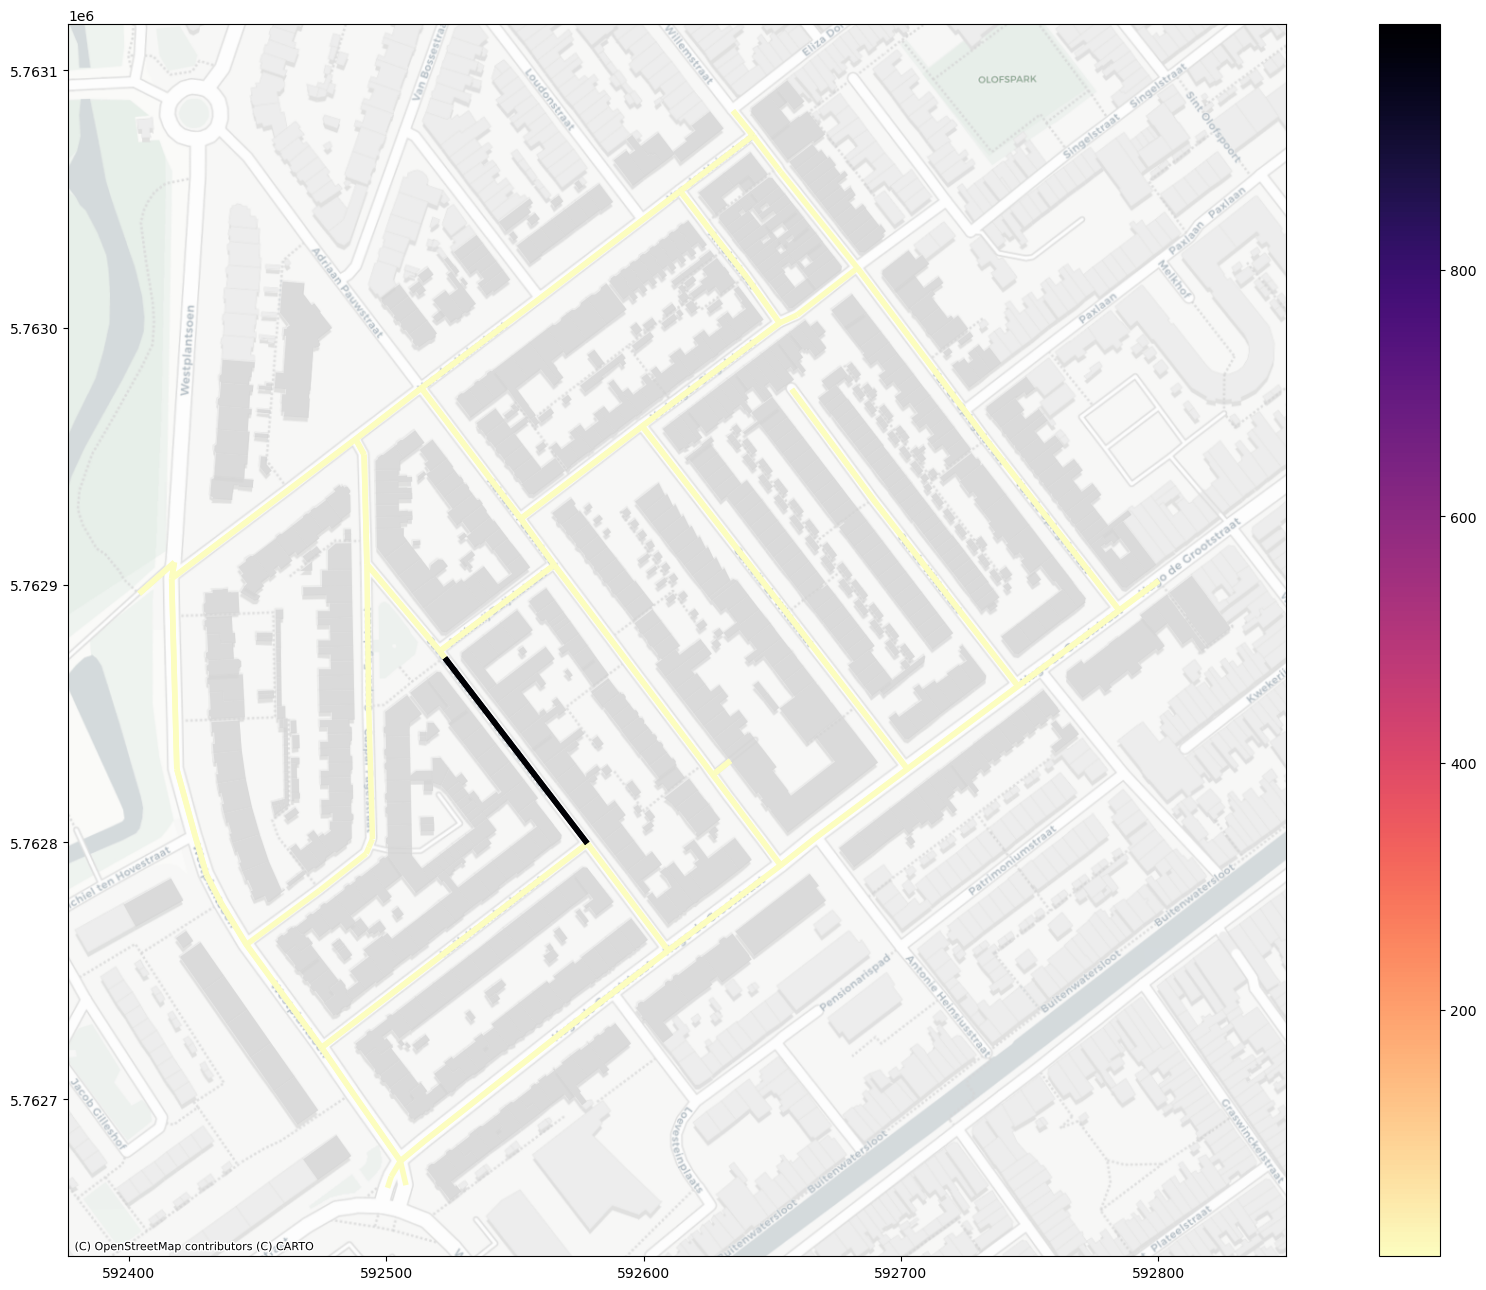

In [24]:
# visuallization of 'weight 

ax = edges.plot(column="K", figsize=(24,16), legend=True, cmap='magma_r', linewidth=4)

# # Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# # Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)


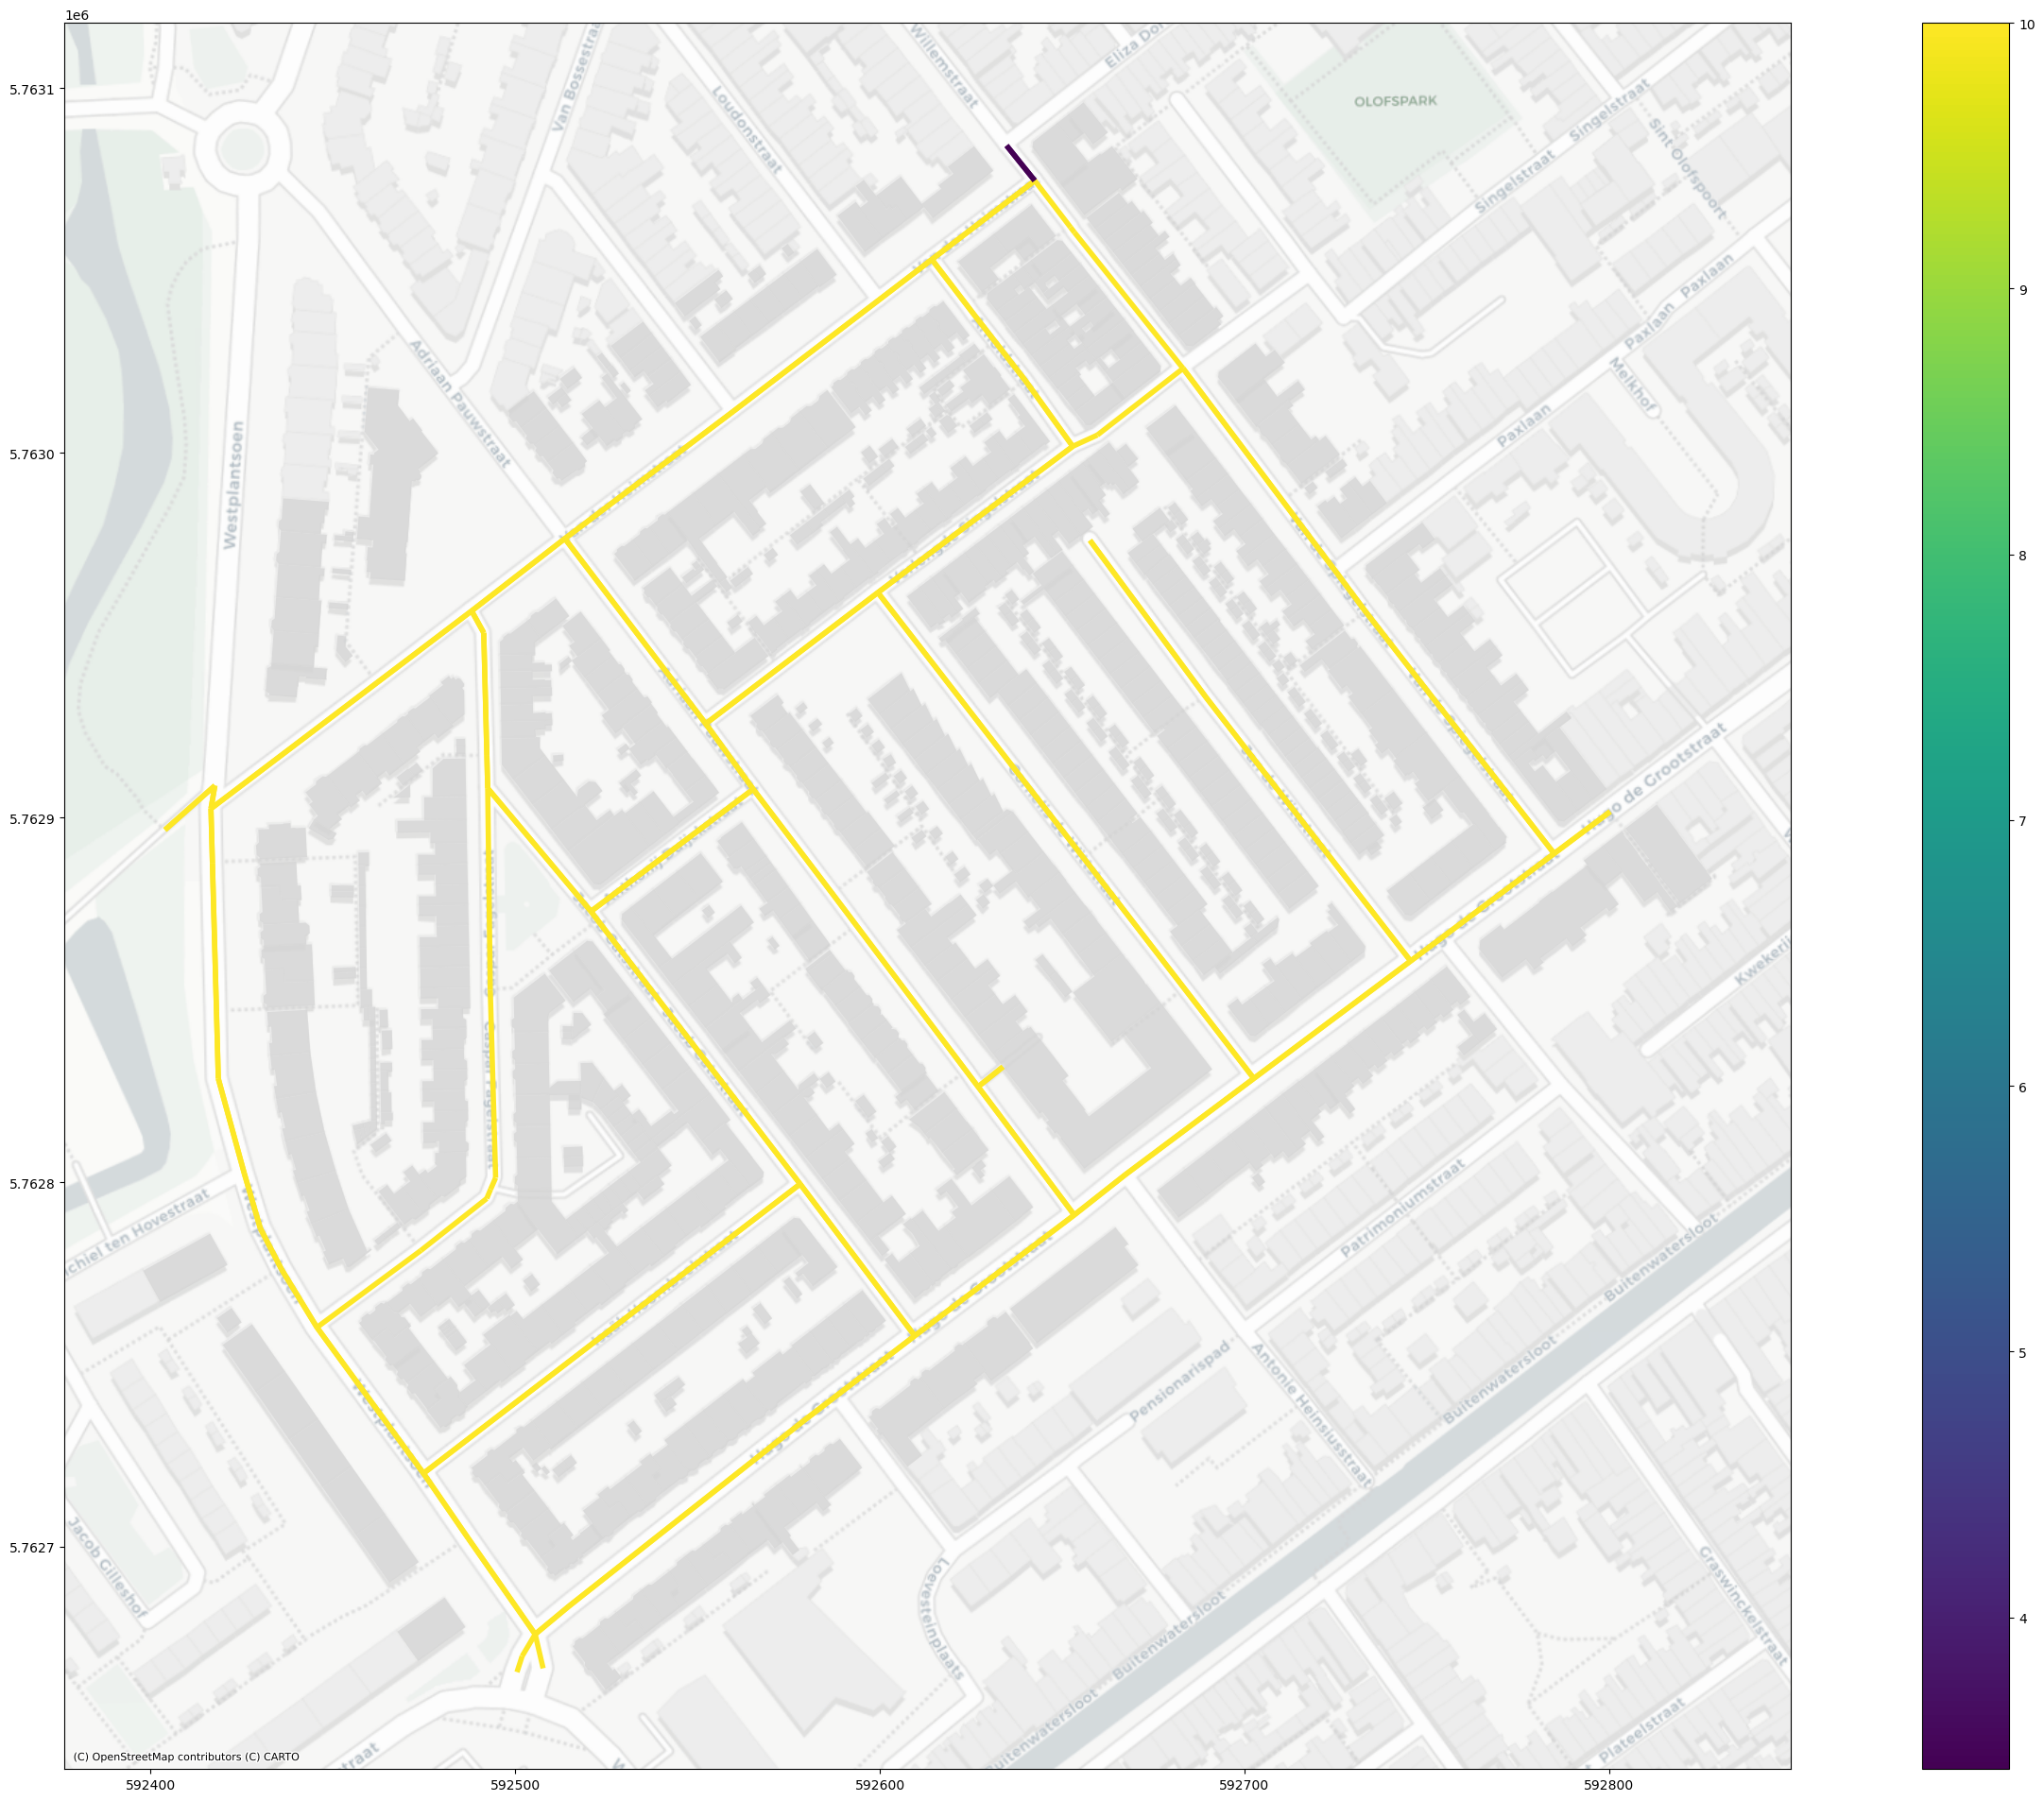

In [25]:
# visuallization of 'weight 

ax = edges.plot(column="useful-width", figsize=(36,24), legend=True, cmap='viridis', linewidth=4)

# # Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# # Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)


In [26]:
center = (52.008879, 4.349493)
m = Map(center=center, basemap=basemaps.CartoDB.Positron, zoom=17, layout=Layout(width='100%', height='600px'))

In [27]:
#style for the destination marker
to_marker_style = AwesomeIcon(
    name='circle',
    icon_color='white',
    marker_color='red',
    spin=False
)
from_marker = Marker(location=center)      # start point = BLUE marker
to_marker = Marker(location=center, icon=to_marker_style)    # end point = RED marker


In [28]:
data = {
  "latitude-y": [52.008236, 52.009476, 52.008471, 52.009309, 52.010014, 52.009187, 52.008176, 52.010223, 52.008886, 52.00891, 52.008435, 52.008528, 52.009221, 52.009552, 52.007444, 52.010052],
  "longtitude-x": [4.347604, 4.348983, 4.349382, 4.350463, 4.349797, 4.348506, 4.348769, 4.349579, 4.347581, 4.347854, 4.349408, 4.34653, 4.346558, 4.347525, 4.347285, 4.348678]
}
#the data above should be created based on QGIS filter in step1
#load data into a DataFrame object:
df_assembly = pandas.DataFrame(data)
lst_assembly = [tuple(r) for r in df_assembly.to_numpy()]

data = {
  "latitude-y": [52.009229, 52.007505, 52.010029, 52.009242],
  "longtitude-x": [4.346595, 4.347407, 4.350257, 4.351449]
}
#the data above should be created based on QGIS filter in step1
#load data into a DataFrame object:
df_shelter = pandas.DataFrame(data)
lst_shelter = [tuple(r) for r in df_assembly.to_numpy()]


In [29]:
def find(marker, lst):
    temp_shortest = 999999
    temp_ind = 0
    for i in lst:
        coord_1 = (marker.location[0], marker.location[1]) #(y,x)
        coord_2 = (float(i[0]), float(i[1])) #(y,x)
        temp_dis = geopy.distance.geodesic(coord_1, coord_2) #count the distance accoring to lat and long
        if temp_dis < temp_shortest:
            temp_shortest = temp_dis
            temp_ind = lst.index(i)
    nearest_shelter = ox.nearest_nodes(graphInter, float(lst[temp_ind][1]), float(lst[temp_ind][0])) 
    return nearest_shelter

In [30]:
path_layer_list = []
def handle_change_location(event, marker, lst1, lst2):
    event_owner = event['owner']
    shortest_path = nx.dijkstra_path(graphInter, find(event_owner, lst1), find(marker, lst2), 
                                     weight='weight')
    if len(path_layer_list) == 1:
        m.remove(path_layer_list[0])
        path_layer_list.pop()
    
    shortest_path_points = nodesInter.loc[shortest_path]
    path = gpd.GeoDataFrame([LineString(shortest_path_points.geometry.values)], columns=['geometry'])
    path_layer = GeoData(geo_dataframe=path, style={'color':'red', 'weight':2})
    m.add(path_layer)
    path_layer_list.append(path_layer)

In [31]:
from_marker.observe(lambda event: handle_change_location(event, to_marker, lst_assembly, lst_shelter), 'location')
to_marker.observe(lambda event: handle_change_location(event, from_marker, lst_shelter, lst_assembly), 'location')

m.add(from_marker)
m.add(to_marker)

display(m)
 # start point = BLUE marker
 # end point = RED marker

Map(center=[52.008879, 4.349493], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …